## Accessing Files in the SMCE
## Computing and plotting storm total rainfall for Hurricane Harvey (2017)
#### Jonathan Case

We will use the following libraries to access and analyze data stored in the SMCE.

In [1]:
import xarray as xr
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
import datetime as dt
import datetime
from datetime import timedelta
import s3fs

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

### Files larger than 10GB

If the file(s) you want to analyze are larger than 10GB, you will have to use the s3 filesystem (s3fs) to access the data. No credentials are required.

In [2]:
server = 's3://nasa-waterinsight/test/NLDAS3_Forcing'
url = f'{server}/201708/NLDAS_FOR0010_H.A20170826.030.beta.nc'
s3 = s3fs.S3FileSystem({'anon':True})
s3.ls('nasa-waterinsight/test/NLDAS3_Forcing/201708/')

['nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170801.030.beta.nc',
 'nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170802.030.beta.nc',
 'nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170803.030.beta.nc',
 'nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170804.030.beta.nc',
 'nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170805.030.beta.nc',
 'nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170806.030.beta.nc',
 'nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170807.030.beta.nc',
 'nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170808.030.beta.nc',
 'nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170809.030.beta.nc',
 'nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170810.030.beta.nc',
 'nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170811.030.beta.nc',
 'nasa-waterinsight/test/NLDAS3_Forcing/201

In [3]:
# NOAA/NWS StageIV/AHPS RGB colorbar colors used at https://water.noaa.gov
under = '#E1E1E1' # light gray
c1 = '#60D0F8'  # light blue
c2 = '#6C9BCC'  # mid blue
c3 = '#494DA5'  # dark blue
c4 = '#5EFB6C'  # light green
c5 = '#52B05B'  # mid green
c6 = '#4A8352'  # dark green
c7 = '#FAFB6E'  # yellow
c8 = '#FDDF8F'  # gold
c9 = '#F8A95E'  # orange
c10 = '#F84553' # red
c11 = '#B9424D' # dark red
c12 = '#944147' # maroon
c13 = '#F840F5' # magenta
c14 = '#9570E0' # purple
over = '#E1E1E1' # light gray

In [14]:
# Rainfall contour intervals in inches. Applying colors above for contour fills.
clevs_pcp_in = [
#    0.0, 0.10, 0.25, 0.50, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 20.0
    1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0
]
fills_pcp_in = [
    c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14
]
cmap = col.LinearSegmentedColormap.from_list('own2', fills_pcp_in)

In [5]:
# Apply geographical extent of plot (lower-left/upper-right lons and lats).
# Set up plotting features.
lonll = -102
lonur = -85
latll = 25
latur = 34
geo = [lonll, lonur, latll, latur]
map_proj = ccrs.PlateCarree()
mapscale ='50m'
coastlines = cfeature.NaturalEarthFeature(
    category='physical',
    name='coastline',
    scale=mapscale,
    edgecolor='black',
    facecolor='none')
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale=mapscale,
    edgecolor='black',
    facecolor='none')
states = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces',
    scale=mapscale,
    edgecolor='black',
    facecolor='none')

In [8]:
# Read in daily forcing files and extract precip grids over geographical subset.
filelist = [
    's3://nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170826.030.beta.nc',
    's3://nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170827.030.beta.nc',
    's3://nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170828.030.beta.nc',
    's3://nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170829.030.beta.nc',
    's3://nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170830.030.beta.nc',
]

first = True
for file in filelist:
    with s3.open(file) as infile:
        print(f'\nopening {infile}')
        ds = xr.open_dataset(infile, engine="h5netcdf")
        #print(ds)
        # extract rainfall forcing over geo region of interest
        pcp = ds['Rainf'].sel(lon=slice(lonll, lonur), lat=slice(latll, latur))
        pcpsum = pcp.sum(dim='time') / 25.4
        print(pcp.sizes)
        if first:
            pcptot = pcpsum
            lats = pcp['lat'].values
            lons = pcp['lon'].values
        else:
            pcptot = pcptot + pcpsum
        # print max daily precip value
        print(f'  -Max daily precip: {pcpsum.max().values:0.2f} inches')
        print(f'  -Max total precip: {pcptot.max().values:0.2f} inches')
        first = False


opening <File-like object S3FileSystem, nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170826.030.beta.nc>
Frozen({'time': 24, 'lat': 900, 'lon': 1700})
  -Max daily precip: 9.42 inches
  -Max total precip: 9.42 inches

opening <File-like object S3FileSystem, nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170827.030.beta.nc>
Frozen({'time': 24, 'lat': 900, 'lon': 1700})
  -Max daily precip: 11.05 inches
  -Max total precip: 18.01 inches

opening <File-like object S3FileSystem, nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170828.030.beta.nc>
Frozen({'time': 24, 'lat': 900, 'lon': 1700})
  -Max daily precip: 11.47 inches
  -Max total precip: 28.16 inches

opening <File-like object S3FileSystem, nasa-waterinsight/test/NLDAS3_Forcing/201708/NLDAS_FOR0010_H.A20170829.030.beta.nc>
Frozen({'time': 24, 'lat': 900, 'lon': 1700})
  -Max daily precip: 12.11 inches
  -Max total precip: 38.58 inches

opening <File-like object S3FileSystem, nasa-

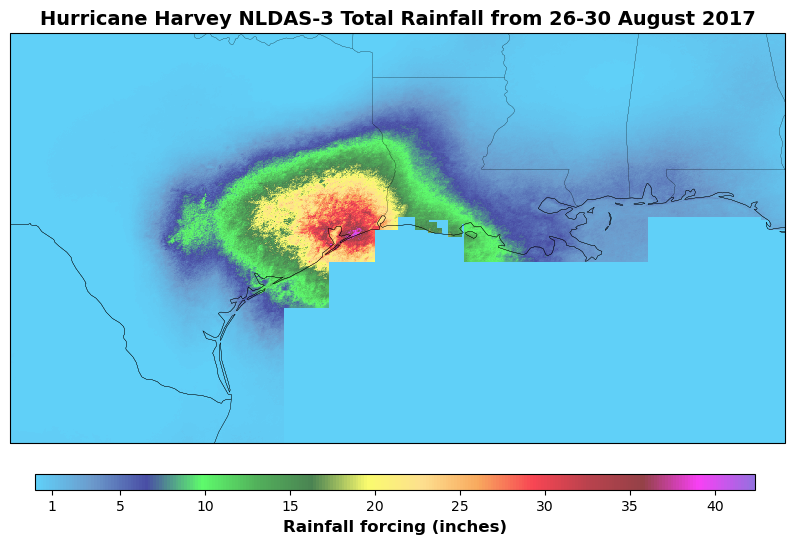

In [35]:
# make plot of final total precip from event
fig, ax = plt.subplots(1, 1, figsize=(10, 8),
                       subplot_kw={'projection': map_proj})
ax.set_extent(geo, crs=map_proj)
# Draw Lats, Lons, Coastlines, Countries, States, and Lakes
# using Natural Earth (public domain http://naturalearthdata.com)
ax.add_feature(coastlines, linewidth=0.2,)
ax.add_feature(countries, linewidth=0.2,)
ax.add_feature(states, linewidth=0.1,)
cs = ax.pcolormesh(lons, lats, pcptot, cmap=cmap)
cs.cmap.set_under(under)
cs.cmap.set_over(over)
# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.15, 0.18, 0.72, 0.02])
cbar = fig.colorbar(cs, cax=cbar_ax, ticks=clevs_pcp_in,
                    orientation='horizontal', extendfrac=0.05)
cbar.set_label('Rainfall forcing (inches)', size=12, weight='bold')
ax.set_title('Hurricane Harvey NLDAS-3 Total Rainfall from 26-30 August 2017', fontsize=14, fontweight='bold')
plt.show()